# Decision Tree Regressor

In dit notebook zal een Decision Tree Regressor model gebruikt worden om de duur van een storing te voorspellen. Dit wordt gedaan met feature variabelen die gevonden en geprepareerd zijn in "DataPrep.ipynb"

In [1]:
# importeren gebruikte libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from baseline import calculate_baseline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from math import sqrt
from tqdm import tqdm
from sklearn.tree import plot_tree
import numpy as np

In [2]:
model_df = pd.read_pickle("data/model_df.pkl")
train_df = pd.read_pickle("data/train_df.pkl")
test_df = pd.read_pickle("data/test_df.pkl")

X_train = train_df.drop('anm_tot_fh', axis=1)
y_train = train_df['anm_tot_fh']

X_test = test_df.drop('anm_tot_fh', axis=1)
y_test = test_df['anm_tot_fh']

## Hyperparameter Tuning

Er wordt een Decision Tree Regressor getraint met de features eerder geprepareerd. Eerst wordt er een test-train split gemaakt om het model mee te trainen en mee te testen. Daarna worden er modellen getraint met verschillende max_depths. Dit wordt geplot en in deze plots is te zien wat een goede depth is voor het model.

In [3]:
depths = range(1, 16) 

train_rmse, test_rmse = [], []
train_r2, test_r2 = [], []

# Train DTR model met verschillende max_depths
for depth in tqdm(depths):
    regressor = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=0.05, criterion='squared_error', random_state=42)
    regressor.fit(X_train, y_train)

    # Voorspellingen op de train set
    train_predictions = regressor.predict(X_train)
    train_rmse.append(sqrt(mean_squared_error(y_train, train_predictions)))
    train_r2.append(r2_score(y_train, train_predictions))

    # Voorspellingen op de test set
    test_predictions = regressor.predict(X_test)
    test_rmse.append(sqrt(mean_squared_error(y_test, test_predictions)))
    test_r2.append(r2_score(y_test, test_predictions))

100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Hieronder wordt gekeken wat voor soort diepte goed is voor dit model. De RMSE en r2 scores worden vergeleken voor de train en de test set. Zoals te zien is er niet super veel verschil tussen de train en test set, wat betekend dat het model niet overfit is. Er is te zien dat de grafiek afvlakt bij diepte 5. Daarom wordt er gekozen voor max_depth = 5.

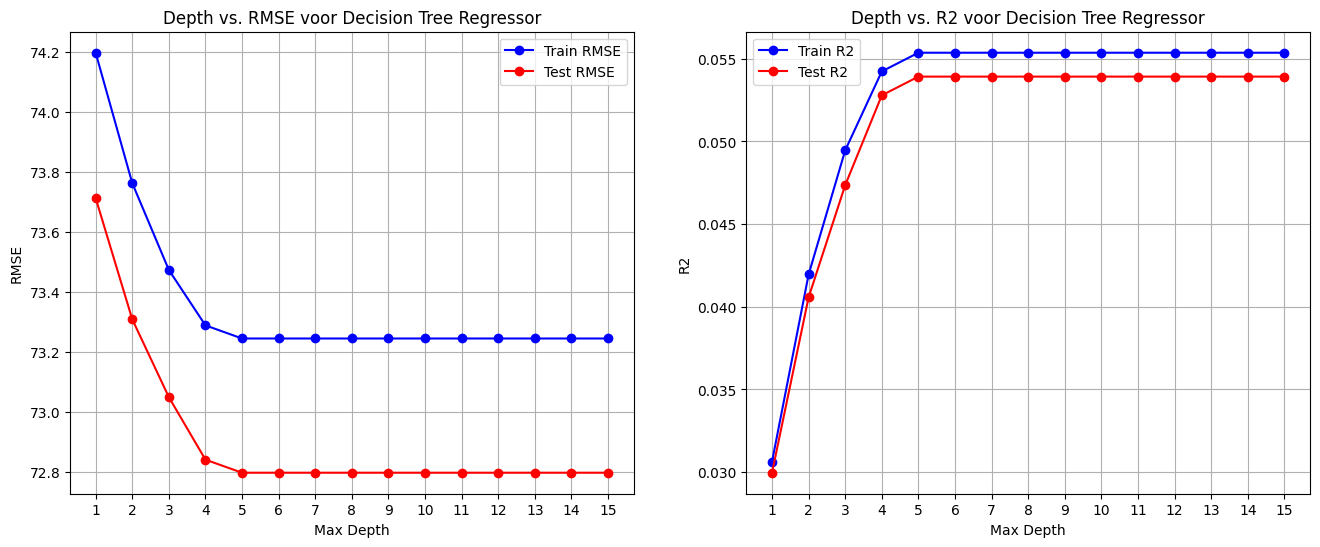

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot RMSE
ax1.plot(depths, train_rmse, marker='o', linestyle='-', color='b', label='Train RMSE')
ax1.plot(depths, test_rmse, marker='o', linestyle='-', color='r', label='Test RMSE')
ax1.set_title('Depth vs. RMSE voor Decision Tree Regressor')
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('RMSE')
ax1.set_xticks(depths)
ax1.grid(True)
ax1.legend()

# Plot R2 score
ax2.plot(depths, train_r2, marker='o', linestyle='-', color='b', label='Train R2')
ax2.plot(depths, test_r2, marker='o', linestyle='-', color='r', label='Test R2')
ax2.set_title('Depth vs. R2 voor Decision Tree Regressor')
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('R2')
ax2.set_xticks(depths)
ax2.grid(True)
ax2.legend()

plt.show()


## Definitieve Model

Hieronder wordt er een model getraint met de gekozen max_depth. Het model wordt gepickled en opgeslagen zodat deze gerbuikt kan worden in de GUI. Daarna worden de scores van het model vergeleken met de baseline scores.

In [5]:
max_depth = 5
regressor = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=0.05, criterion='squared_error', random_state=42)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

y_pred = regressor.predict(X_test)

# pickle de regressor voor gebruik in de GUI
with open('models/DecisionTreeRegressor.pkl', 'wb') as file:
    pickle.dump(regressor, file)

print("Root Mean Squared Error: ", rmse)
print("R-squared (R2) Score: ", r2)

baseline_rmse, baseline_r2 = calculate_baseline(model_df)
print('Baseline RMSE: ', baseline_rmse)
print('Baseline R2: ', baseline_r2)

Root Mean Squared Error:  72.79606871062117
R-squared (R2) Score:  0.05392551006272206
Baseline RMSE:  75.25674049973072
Baseline R2:  0.0


Het model is met een minimaal verschil beter dan de baseline (de RMSE is een beetje lager en de R2 score is een heel klein beetje hoger).

## Decision Tree Probability

In dit hoofdstuk wordt er verder gekeken naar het gevonden model.

Eerst worden de RMSE scores van elke leaf berekend. Als sommige scores een stuk lager zijn dan andere weten we dat er bepaalde voorspellingen heel goed zijn en andere een stuk minder

In [6]:
# Krijg de leaf nodes
leaf_nodes = [i for i in range(regressor.tree_.node_count) if regressor.tree_.children_left[i] == regressor.tree_.children_right[i]]

rmse_per_leaf = {}

# Loop over alle leaf nodes en bereken de RMSE
for idx in leaf_nodes:
    samples_in_node = regressor.tree_.n_node_samples[idx]
    if samples_in_node > 0:
        node_rmse = sqrt(regressor.tree_.impurity[idx] * samples_in_node / (samples_in_node + 1)) 
        rmse_per_leaf[idx] = node_rmse
        print("Leaf Node {} has RMSE {}".format(idx, node_rmse))
        
# Krijg de voorspelling per leaf node
pred_per_leaf = {idx: regressor.tree_.value[idx][0][0] for idx, _ in rmse_per_leaf.items()}

Leaf Node 2 has RMSE 41.030510172260975
Leaf Node 6 has RMSE 57.85313354107103
Leaf Node 7 has RMSE 58.71448937522106
Leaf Node 9 has RMSE 61.14452267000734
Leaf Node 10 has RMSE 65.93379225369496
Leaf Node 12 has RMSE 68.95316838067572
Leaf Node 13 has RMSE 70.94219009098663
Leaf Node 18 has RMSE 69.2379512791754
Leaf Node 19 has RMSE 74.79531136496867
Leaf Node 20 has RMSE 76.60856332730225
Leaf Node 23 has RMSE 77.45662042888817
Leaf Node 24 has RMSE 79.78875405297985
Leaf Node 25 has RMSE 84.73003955857183
Leaf Node 27 has RMSE 86.02603602526418
Leaf Node 29 has RMSE 86.0385342080453
Leaf Node 30 has RMSE 93.90089627202542


Hieronder wordt de decision tree geplot. Met behulp van dit figuur kunnen we zien op basis van welke features het model splits heeft gemaakt en welke dus belangrijk zijn. 

In [7]:
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

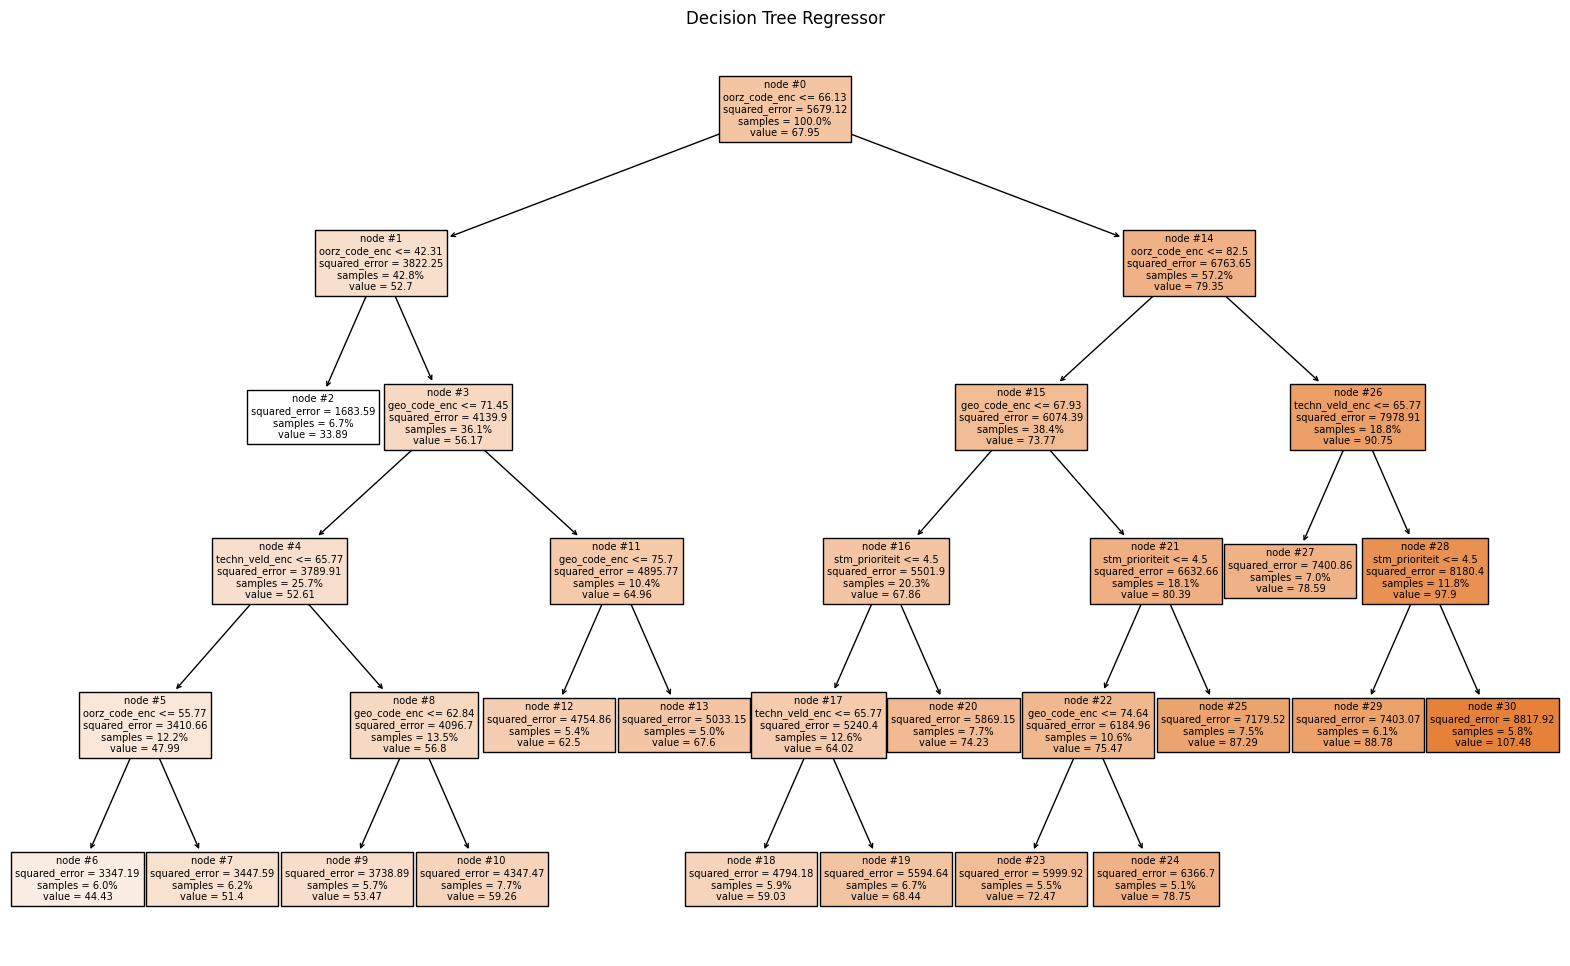

In [8]:
plt.figure(figsize=(20, 12)) 
plot_tree(regressor, filled=True, proportion=True, impurity=True, precision=2, feature_names=list(X.columns), node_ids=True)
plt.title("Decision Tree Regressor")
plt.show()

Hieronder wordt een grafiek gemaakt om historische data van 1 specifieke leaf uit de decision tree te laten zien.

In [9]:
leaf_indices = regressor.apply(X)

samples_in_leaves = {}

# Iterate over unique leaf indices
unique_leaf_indices = np.unique(leaf_indices)
for leaf_index in unique_leaf_indices:
    # Select the target values (y) that belong to the current leaf
    samples_in_leaves[leaf_index] = y[leaf_indices == leaf_index].tolist()


In [10]:
leaf = 2
durations = np.array(samples_in_leaves[leaf])
mean_prediction = pred_per_leaf[leaf]

percentile_95 = np.percentile(durations, 95)

In de plot hieronder wordt een histogram gemaakt van de historische storingsduur data uit een specifieke leaf. De voorspelling die gemaakt wordt vanuit die leaf is ook te zien. Het blauwe gedeelte geeft aan hoeveel procent van de data onder de voorspelling ligt en het oranje hoeveel erboven. De groene lijn is de 95% lijn. Dit betekend dat 95% van de voorspellingen tussen de 5 min en deze waarde liggen. Deze informatie zal weergegeven worden in de dashboard.

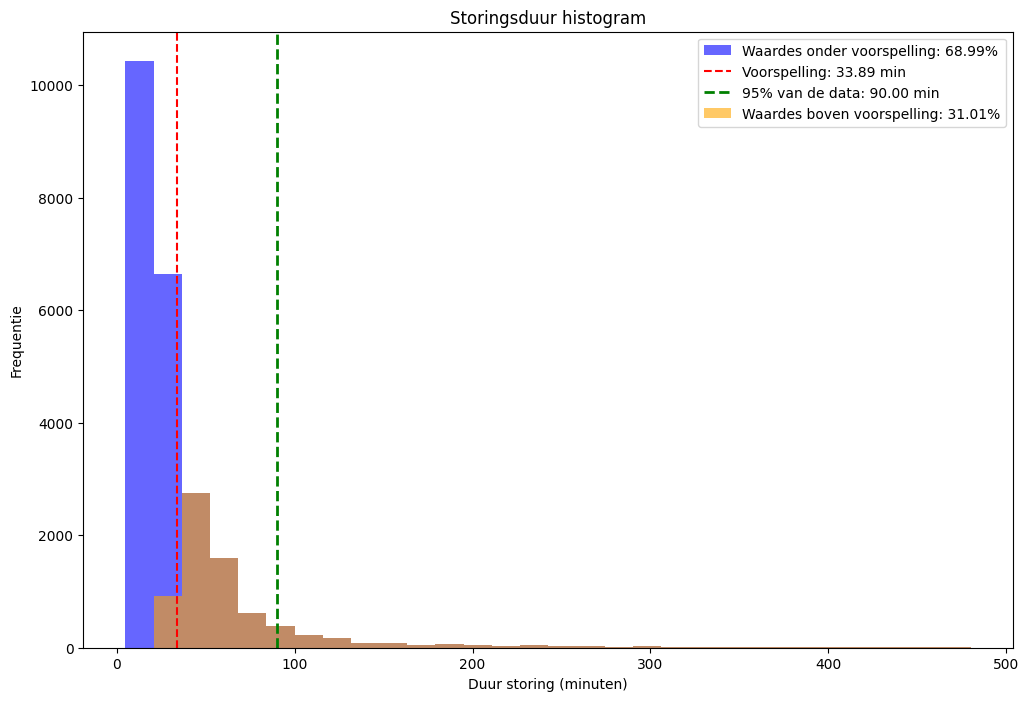

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
_, bins, _ = ax.hist(durations, bins=30, density=False, alpha=0.6, color='b', label='Historische storingsduur Data')
ax.axvline(mean_prediction, color='r', linestyle='--', label=f'Mean Prediction = {mean_prediction:.0f}')
ax.axvline(percentile_95, color='g', linestyle='--', label='95% Mark', linewidth=2)
ax.set_xlabel('Duur storing (minuten)')
ax.set_ylabel('Frequentie')
ax.set_title('Storingsduur histogram')

values_below_mean_prediction = durations[durations < mean_prediction]
values_above_mean_prediction = durations[durations >= mean_prediction]
percentage_below_mean = len(values_below_mean_prediction) / len(durations) * 100
percentage_above_mean = len(values_above_mean_prediction) / len(durations) * 100

n, bins, patches = ax.hist(values_above_mean_prediction, bins=bins, alpha=0.6, color='orange', label=f'Values Above Mean Prediction: {percentage_above_mean:.2f}%')

labels = [
    f'Waardes onder voorspelling: {percentage_below_mean:.2f}%', 
    f'Voorspelling: {mean_prediction:.2f} min',
    f'95% van de data: {percentile_95:.2f} min', 
    f'Waardes boven voorspelling: {percentage_above_mean:.2f}%'
    ]
ax.legend(labels=labels)

plt.show()
